<a href="https://colab.research.google.com/github/tridev003/Whatsapp-Chat-Analyzer/blob/main/WhatsappChatAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wordcloud
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
nltk.download('wordnet')
lm = WordNetLemmatizer()
ps = PorterStemmer()

First, in order to detect if a line of text is a new message or belongs to a multi-line message, we will have to check if that line begins with a Date and Time

In [ ]:
def startsWithDate(s):
  pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([1-9]|[1-2][0-2]):([0-9][0-9]) (a|p)m -'
  result = re.match(pattern,s)
  if(result):
    return True
  return False

Our objective is to detect the author of this message.

In [ ]:
def startsWithAuthor(s):
  patterns = [
              '([\s]+[\w]+):',
              '([\s]+[\w]+[\s]+[\w]+):',
              '([\s]+[\w]+[\s]+[(][Pp][Uu][)]):',
              '([\s]+[+]\d{2} \d{5} \d{5}):'
  ]
  pattern = '^' + '|'.join(patterns)
  result = re.match(pattern,s)
  if result:
    return True
  return False

Let us define a new method called getDataPoint for the task of splitting string based on the separator tokens to extract the tokens of interest:

In [ ]:
def getDataPoint(line):
  #18/01/2020, 10:50 pm - Rahul Singh: m kya geet gaa rha hu kya itni der se
  splitLine = line.split('-')

  dateTime = splitLine[0]
  date,time = dateTime.split(', ')

  message = ' '.join(splitLine[1:])

  if startsWithAuthor(message):#True
    splitMessage = message.split(': ')
    author = splitMessage[0]
    message = ' '.join(splitMessage[1:])

  else: 
    author = None
  
 
  return date, time , author , message


Parsing the entire file and handling Multi-Line Message

In [ ]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

conversationPath = '/content/WhatsApp Chat.txt'
with open(conversationPath , encoding = "utf-8" ) as fp:
  fp.readline() # Skipping first line of the file (usually contains information about end-to-end encryption)
  
  messageBuffer = [] # Skipping first line of the file (usually contains information about end-to-end encryption)
  date,time,author =None,None,None  # Intermediate variables to keep track 
  
  while(True):
    line = fp.readline()
    if not line:  # Intermediate variables to keep track of the current message being processed
      break

    line = line.strip()     # Guarding against erroneous leading and trailing whitespaces
    if startsWithDate(line): # If a line starts with a Date Time pattern, then this indicates the beginning of a new message
      if len(messageBuffer) > 0 : # Check if the message buffer contains characters from previous iterations
        parsedData.append([date,time,author, ' '.join(messageBuffer)]) # Save the tokens from the previous message in parsedData
      messageBuffer.clear() # Clear the message buffer so that it can be used for the next message
      date,time,author,message = getDataPoint(line) # Identify and extract tokens from the line
      messageBuffer.append(message) # Append message to buffer
      
    else:
      messageBuffer.append(line)  # If a line doesn't start with a Date Time pattern, then it is part of a multi-line message. So, just append to buffer


In [ ]:
df = pd.DataFrame(parsedData, columns = ['Date','Time','Author','Message'])
df.head(100)

DATA EXPLORATION


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23266 entries, 0 to 23265
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     23266 non-null  object
 1   Time     23266 non-null  object
 2   Author   23204 non-null  object
 3   Message  23266 non-null  object
dtypes: object(4)
memory usage: 727.2+ KB


In [ ]:
df.describe()

Date      Time         Author          Message
count        23266     23266          23204            23266
unique         195      1203             13            18445
top     10/08/2020  8:56 pm    Rishabh (PU)  <Media omitted>
freq           974        75           5616             1295

Let's correct some Author names


In [ ]:
df.Author.unique()

array([None, ' Rishabh (PU)', ' Rahul Singh', ' Aniket', ' Praful',
       ' Prakhar', ' Rahul Nyati', ' Mudrik', ' Rahul (pu)', ' Shivam',
       ' Dharmesh (PU)', ' Kapil', ' Dalbhanjan', ' Yash Porwal'],
      dtype=object)

In [ ]:
df.Author.replace(to_replace = [' Rishabh (PU)',' Rahul Singh',' Rahul (pu)',' Dharmesh (PU)'],value = ['Rishabh','Tridev','Rahul Singh ','Dharmesh'],inplace = True)
df['Author'].unique()

array([None, 'Rishabh', 'Tridev', ' Aniket', ' Praful', ' Prakhar',
       ' Rahul Nyati', ' Mudrik', 'Rahul Singh ', ' Shivam', 'Dharmesh',
       ' Kapil', ' Dalbhanjan', ' Yash Porwal'], dtype=object)

Messages With No Authors

In [ ]:
null_authors_df = df[df['Author'].isnull()]
print(len(null_authors_df))
null_authors_df

62


Date  ...                                            Message
0      18/01/2020  ...                      You created group "hackathon"
1      18/01/2020  ...                                  You added Prakhar
986    03/02/2020  ...                                       Prakhar left
1127   14/02/2020  ...   Rishabh (PU) changed the subject from "hackat...
1144   14/02/2020  ...   Aniket changed the subject from "Centre Of Ex...
...           ...  ...                                                ...
17810  03/08/2020  ...                            You removed Yash Porwal
17811  03/08/2020  ...                                  You removed Kapil
18227  04/08/2020  ...                               You added Rahul (pu)
18280  04/08/2020  ...                                    You added Kapil
18340  06/08/2020  ...                                 Dharmesh (PU) left

[62 rows x 4 columns]

Media Overload(including photos, videos, GIFs, contacts, locations, audio messages and documents)

1295


Text(0, 0.5, 'Group Members')

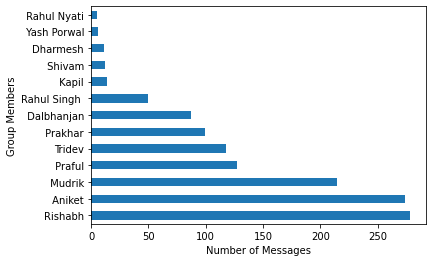

In [ ]:
media_message_df = df[df['Message'] == '<Media omitted>']
print(len(media_message_df))

author_media_message_value_counts = media_message_df['Author'].value_counts()
author_media_message_value_counts.plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Group Members')

 let us create a new data frame (messages_df) by dropping all those messages that are either media messages or do not have an author

In [ ]:
messages_df = df.drop(null_authors_df.index)
messages_df = messages_df.drop(media_message_df.index)
messages_df = messages_df.reset_index(drop =True)

In [ ]:
messages_df.head(5)

Date  ...                                            Message
0  18/01/2020  ...  https://www.maketecheasier.com/platforms build...
1  18/01/2020  ...  https://analyticsindiamag.com/5 open source ml...
2  18/01/2020  ...  Problem Statement Manage the data of book in t...
3  18/01/2020  ...                       http://aarohan.poornima.org/
4  18/01/2020  ...  if anyone from this group is not intrested in ...

[5 rows x 4 columns]

Remove Hyperlinks from Messages

In [ ]:
for index,row in messages_df.iterrows():
  hyperlink = messages_df['Message'][index]

  if "http" in hyperlink:
    messages_df = messages_df.drop(index)
  else:
    pass
messages_df = messages_df.reset_index(drop =True)

In [ ]:
messages_df.head(20)

Who is the happiest ?



In [ ]:
def happy_emoji(string):
  emoji_pattern = re.compile('🤗|😋|🤭|😜|😘|🤩|🤣|😉|😊|🙂|😇|😊|😂|🤣|😅|😆|😁|😄|😃|😀|🥳|😎|😀|😀|😄|😁|😆|😅|😂|😉|😇|🤩|😍|🤪|😝|😋|😜')
  result = emoji_pattern.findall(string)
  if(result):
    return True
  return False


Most Disappointed Person

In [ ]:
def disappointed_emoji(string):
  emoji_pattern = re.compile('🙅‍♂️|🙆‍♂️|🙅‍♂️|😬|🙄|🙄|😒|😏|😶|😑|😐|🤐|🤐|😐|😑|😶|😏|😒|🙄|😬|🤥|😔|😌')
  result = emoji_pattern.findall(string)
  if(result):
    return True
  return False

Most Angry Person

In [ ]:
def angry_emoji(string):
  emoji_pattern = re.compile('😤|😡|😠|🤬|😈|🤬')
  result = emoji_pattern.findall(string)
  if(result):
    return True
  return False

Most Concerned Person

In [ ]:
def concerned_emoji(string):
  emoji_pattern =re.compile('🙁|☹|😳|😖|😫|😩|😧|😞|😭|😢|😣|😓|😥|😰|😲|😯|😟|😕|😔|😕|😟|🙁|😮|☹|😯|😲|😳|😦|😧|😨|😰|😥|😢|😱|😖|😞|😣|😓|😩|😫')
  result = emoji_pattern.findall(string)
  if(result):
    return True
  return False

Most Sick person

In [ ]:
def sick_emoji(string):
  emoji_pattern = re.compile('😷|🤒|🤕|🤢|🤮|🤧|🥵|🥴|😵')
  result = emoji_pattern.findall(string)
  if(result):
    return True
  return False

In [ ]:
messages_df['Happy'] = np.nan
messages_df['Disappointed'] = np.nan
messages_df['Angry'] = np.nan
messages_df['Concerned'] = np.nan
messages_df['Sick'] = np.nan

messages_df.head()

Date      Time   Author  ... Angry  Concerned  Sick
0  18/01/2020  5:10 pm   Rishabh  ...   NaN        NaN   NaN
1  18/01/2020  9:40 pm    Tridev  ...   NaN        NaN   NaN
2  18/01/2020  9:40 pm    Aniket  ...   NaN        NaN   NaN
3  18/01/2020  9:41 pm    Tridev  ...   NaN        NaN   NaN
4  18/01/2020  9:41 pm    Praful  ...   NaN        NaN   NaN

[5 rows x 9 columns]

In [ ]:


for index, row in messages_df.iterrows():
  message = messages_df['Message'][index]
  happy_result  = happy_emoji(message)
  disappointed_result = disappointed_emoji(message)
  angry_result = angry_emoji(message)
  concerned_result = concerned_emoji(message)
  sick_result = sick_emoji(message)
  messages_df['Happy'][index] =np.where(happy_result == True,1,0) 
  messages_df['Disappointed'][index] =np.where(disappointed_result == True,1,0) 
  messages_df['Angry'][index] =np.where(angry_result == True,1,0) 
  messages_df['Concerned'][index] =np.where(concerned_result == True,1,0) 
  messages_df['Sick'][index] =np.where(sick_result == True,1,0) 




In [ ]:
messages_df[:].sum()

Date            18/01/202018/01/202018/01/202018/01/202018/01/...
Time            5:10 pm 9:40 pm 9:40 pm 9:41 pm 9:41 pm 9:41 p...
Author          RishabhTridev AniketTridev Praful PrafulTridev...
Message         Problem Statement Manage the data of book in t...
Happy                                                        2084
Disappointed                                                  107
Angry                                                          11
Concerned                                                     136
Sick                                                           14
dtype: object

since the values in the angry and sick coloumn are too less..lets drop them

In [ ]:
messages_df = messages_df.drop('Angry',axis =1)
messages_df = messages_df.drop('Sick',axis =1)
messages_df.head()


Date      Time   Author  ... Happy  Disappointed  Concerned
0  18/01/2020  5:10 pm   Rishabh  ...   0.0           0.0        0.0
1  18/01/2020  9:40 pm    Tridev  ...   0.0           0.0        0.0
2  18/01/2020  9:40 pm    Aniket  ...   0.0           0.0        0.0
3  18/01/2020  9:41 pm    Tridev  ...   0.0           0.0        0.0
4  18/01/2020  9:41 pm    Praful  ...   0.0           0.0        0.0

[5 rows x 7 columns]

In [ ]:
happy_authors = messages_df['Happy'].groupby(messages_df['Author'])
disappointed_authors = messages_df['Disappointed'].groupby(messages_df['Author'])
concerned_authors = messages_df['Concerned'].groupby(messages_df['Author'])
happy_authors

In [ ]:
happy_data = messages_df.groupby(['Author']).agg(
    {"Happy":{"sum"}}
)
#happy_data = happy_data.apply(lambda x : x.sort_values(["Happy"],ascending = False)).reset_index(drop =True)
print(happy_data)

              Happy
                sum
Author             
 Aniket       381.0
 Dalbhanjan   126.0
 Kapil          6.0
 Mudrik       626.0
 Praful       125.0
 Prakhar      208.0
 Rahul Nyati    5.0
 Shivam         2.0
 Yash Porwal   32.0
Dharmesh       13.0
Rahul Singh     9.0
Rishabh       381.0
Tridev        170.0


In [ ]:
disappointed_data = messages_df.groupby(['Author']).agg(
    {"Disappointed":{"sum"}}
)
print(disappointed_data)

             Disappointed
                      sum
Author                   
 Aniket              31.0
 Dalbhanjan          16.0
 Kapil                0.0
 Mudrik              15.0
 Praful               4.0
 Prakhar             14.0
 Rahul Nyati          0.0
 Shivam               0.0
 Yash Porwal          1.0
Dharmesh              0.0
Rahul Singh           0.0
Rishabh              20.0
Tridev                6.0


In [ ]:
concerned_data = messages_df.groupby(['Author']).agg(
    {"Concerned":{"sum"}}
)
print(concerned_data)

             Concerned
                   sum
Author                
 Aniket            7.0
 Dalbhanjan       22.0
 Kapil             0.0
 Mudrik            7.0
 Praful            4.0
 Prakhar           9.0
 Rahul Nyati       0.0
 Shivam            0.0
 Yash Porwal       5.0
Dharmesh           0.0
Rahul Singh        0.0
Rishabh           63.0
Tridev            19.0


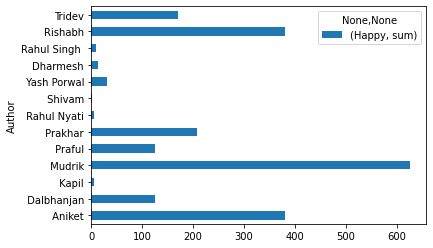

In [ ]:
fig = happy_data.plot.barh()
fig.figure.show()


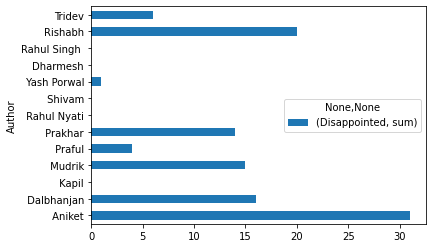

In [ ]:
fig = disappointed_data.plot.barh()
fig.figure.show()

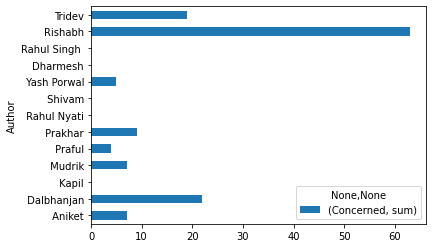

In [ ]:
fig = concerned_data.plot.barh()
fig.figure.show()

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [ ]:
for index,row in messages_df.iterrows():
      message = messages_df['Message'][index]
      message=  remove_emoji(message) #remove all emojis
      message = message.lower() #convert to lower case letters
      message = re.sub('[^a-zA-z]' ,' ',message) #remove punctuation
      message = message.split() #split for stemming/lemmatization and stopwords

      message = [lm.lemmatize(word) for word in message if not word in set(stopwords.words('english')) ]
      message = ' '.join(message)
      messages_df['Message'][index]= message
      

In [ ]:
print(messages_df['Message'].value_counts().head(100).to_string())

In [ ]:
messages_df.head(10)

Highly Talkative

Text(0, 0.5, 'Group Members')

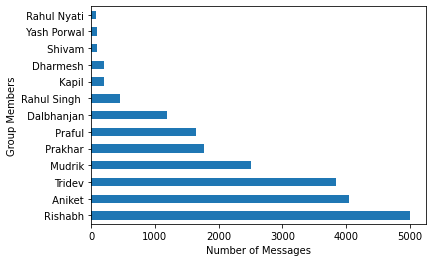

In [ ]:
author_value_counts = messages_df['Author'].value_counts()
author_value_counts.plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Group Members')

 let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”

In [ ]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

In [ ]:
messages_df.head()

Date      Time  ... Letter_Count Word_Count
0  18/01/2020  5:10 pm   ...          224         34
1  18/01/2020  9:40 pm   ...          115         15
2  18/01/2020  9:40 pm   ...            5          2
3  18/01/2020  9:41 pm   ...           12          2
4  18/01/2020  9:41 pm   ...            9          3

[5 rows x 6 columns]

In [ ]:
messages_df.columns

Index(['Date', 'Time', 'Author', 'Message', 'Letter_Count', 'Word_Count'], dtype='object')

In [ ]:
discrete_columns = ['Date','Time','Author','Message']
messages_df[discrete_columns].describe()


Date      Time   Author Message
count        21099     21099    21099   21099
unique         187      1191       13   16245
top     10/08/2020  8:56 pm   Rishabh        
freq           900        71     4999    2202

In [ ]:
continuous_columns = ['Letter_Count','Word_Count']
messages_df[continuous_columns].describe()

Letter_Count    Word_Count
count  21099.000000  21099.000000
mean      21.732926      4.618181
std       27.537434      4.933014
min        0.000000      1.000000
25%        6.000000      1.000000
50%       17.000000      4.000000
75%       29.000000      6.000000
max     1090.000000    141.000000

How many words and letters have been sent since the beginning of time

In [ ]:
messages_df['Letter_Count'].sum(),messages_df['Word_Count'].sum()

(458543, 97439)

How many words have been sent in total by each author, since the beginning of time?

Text(0, 0.5, 'Authors')

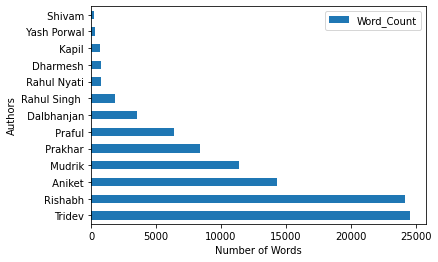

In [ ]:
total_word_count_grouped_by_author = messages_df[['Author','Word_Count']].groupby('Author').sum()
total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count',ascending = False)
total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

What is the most common number of words in a message?

Text(0, 0.5, 'Frequency')

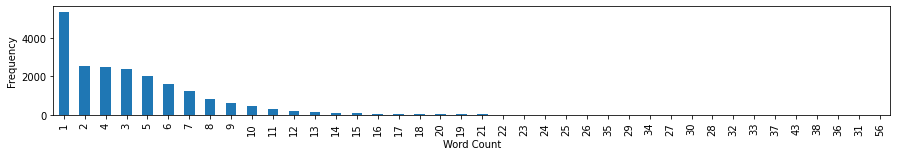

In [ ]:
plt.figure(figsize = (15,2))
word_count_value_count = messages_df['Word_Count'].value_counts()
top_40_word_count_value_count  = word_count_value_count.head(40)
top_40_word_count_value_count.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

What is the most common number of letters in a message?

Text(0, 0.5, 'Frequency')

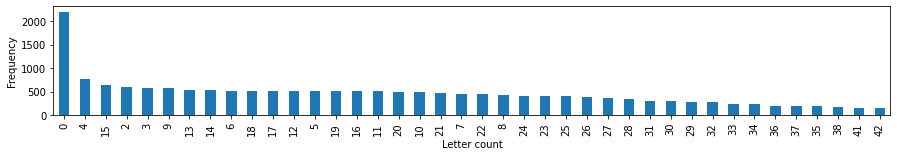

In [ ]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_40_letter_count_value_counts = letter_count_value_counts.head(40)
top_40_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

date on which the most number of messages were sent in the history of your group? 

Text(0, 0.5, 'Date')

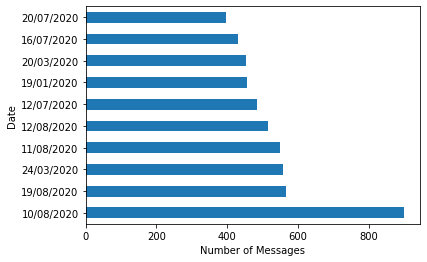

In [ ]:
messages_df['Date'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Most Active Time of the day

Text(0, 0.5, 'Time')

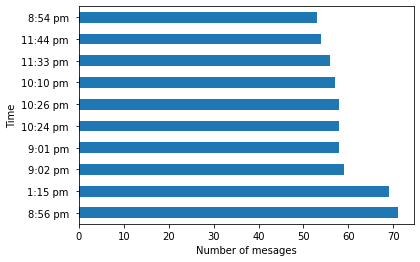

In [ ]:
messages_df['Time'].value_counts().head(10).plot.barh()
plt.xlabel('Number of mesages')
plt.ylabel('Time')

In [ ]:
messages_df.head()

Date      Time  ... Letter_Count Word_Count
0  18/01/2020  5:10 pm   ...          224         34
1  18/01/2020  9:40 pm   ...          115         15
2  18/01/2020  9:40 pm   ...            5          2
3  18/01/2020  9:41 pm   ...           12          2
4  18/01/2020  9:41 pm   ...            9          3

[5 rows x 6 columns]

Creating a new coloumn("Hour")to know the most acive hour 

In [ ]:
messages_df["Hour"] = ""
for index,rows in messages_df.iterrows():
    time = messages_df['Time'][index]
    hour,min = time.split(':')
    min,zone = min.split()
    time_zone = hour +  zone
    
    messages_df['Hour'][index] = time_zone


In [ ]:
messages_df[['Time','Hour']].head(10)

Time  Hour
0   5:10 pm    5pm
1   9:40 pm    9pm
2   9:40 pm    9pm
3   9:41 pm    9pm
4   9:41 pm    9pm
5   9:41 pm    9pm
6   9:42 pm    9pm
7  10:34 pm   10pm
8  10:36 pm   10pm
9  10:36 pm   10pm

Looks like messaging between 8 PM and 11 pm PM has the highest chances of eliciting responses from group members.

Text(0, 0.5, 'Hour of Day')

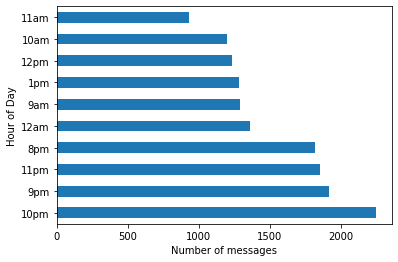

In [ ]:
messages_df['Hour'].value_counts().head(10).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

In [ ]:
#filename = "/content/Clean_text.txt"
with open('Clean_text.txt','w') as file:
  for i in messages_df['Message']:
    file.write(f'{i}')
  file.close()

In [ ]:
import wordcloud
file_content = open("Clean_text.txt").read()
fontpath = None
cloud = wordcloud.WordCloud(font_path=fontpath, width=800, height=400, scale=9, max_words=200, 
                                stopwords=wordcloud.STOPWORDS, background_color='white', font_step=1, 
                                colormap='viridis',collocations = False ).generate(file_content)


In [ ]:
plt.figure(figsize = (10,6),dpi = 1000)
plt.imshow(cloud,interpolation = 'nearest')
plt.axis('off')
plt.tight_layout(pad =0)
plt.show()


In [ ]:

from PIL import Image
mask  = np.array(Image.open('/content/datasets_24780_31574_upvote.png'))


In [ ]:


file_content = open("Clean_text.txt").read()
fontpath = None
cloud = wordcloud.WordCloud(font_path=fontpath, width=800, height=400, scale=9, max_words=200, 
                                stopwords=wordcloud.STOPWORDS, background_color='white', font_step=1, 
                    collocations = False,colormap='Set2',mask =mask ).generate(file_content)




In [ ]:
plt.figure(figsize = (10,6),dpi = 1000)
plt.imshow(cloud,interpolation = 'nearest')
plt.axis('off')
plt.tight_layout(pad =0)
plt.show()